In [2]:
import pandas as pd
import numpy as np 


In [101]:
df = pd.read_csv("IodineExfiltrationAttackFQDNs.csv", header=None, names=['Encoded data'])
df.head(5)

,Encoded data
0,b'0zaat\xde\xd0w4\xe4j\xef\xd6\xdfA\xfc\xcfY\x...
1,b'0zaabV2k5jsl\xbf\xecg\xc9\xddY\xe6e\xfcd\xdb...
2,b'0izacY\xd3\xd3\xd4\xfabbw07hU\xc6u9\xdd\xfb\...
3,b'0yhbp82\xbey\xeeb\xe1\xfdaabacuaa\xc31s\xd2a...
4,b'0qja7\xe2\xc3tpbae\xedQW\xf9pfZ\xc36\xc1j3\x...


For our evaluation, let us take a sample size of 250,000




In [102]:
newDf = df.sample(n=250000, random_state=8)
newDf.astype(str)
newDf

,Encoded data
701735,b'0mtal\xe1NaV\xfa5\xc3Q\xc9\xfc\xc6\xc9Wp\xfc...
1701229,b'0bkblO\xf4\xefQn\xd5\xe5iK5\xebHa\xcc\xed\xe...
2185313,b'02vax7\xc00v\xcf\xd4\xbc1\xf2dvH\xcb\xefcis\...
1918725,b'0mvah\xec\xc4r\xbf\xc8\xf1epWI0C\xdb\xd8X\xe...
2051297,b'0alaj\xe2\xde\xd7t\xf0\xfc2\xear\xf9\xe8\xf1...
...,...
117122,b'0faa4iC\xfc\xe7\xd4\xc0f\xc4\xe4J\xbcZ\xfc\x...
1679625,b'03obq\xceSq\xd0l\xd4\xe3\xd8\xc5y\xfc\xfb\xe...
2134408,b'0adb082\xca2hb\xbe\xee\xf0\xd6gjk\xfd\xc1\xb...
2109579,b'02mad\xc0Q\xbf\xc6D\xe3\xd1\xd4zK\xfc\xc6\xf...


In [103]:
newDf = newDf.reset_index(drop=True)

Let us create features for our dataset

**Now let us create some helper funtions to obtain our features**

In [104]:
# function to count the number of digits
def numOfDigits(input_string):
    d=0
    for c in input_string:
        if c.isdigit():
            d=d+1
        else:
            pass
    return d

In [105]:
import re

def countUppercase(input_string):
    count = len(re.findall(r'[A-Z]',input_string))
    return count


In [106]:
def countLowerCase(input_string):
    count = len(re.findall(r'[a-z]',input_string))
    return count

In [107]:
# count of labels in DNS query
def numOfLables(input_query):
    d=0
    for c in input_query:
        if c == '.':
            d+=1
    return d

In [108]:
# fucntion to calculate the length of the subdomain
def countOfCharsinSubdomain(input_query):
    tempList = input_query.split('.')
    sundomain = tempList[0:-2]
    sd = ''.join([str(item) for item in sundomain])
    return len(sd)

In [109]:
# fucntion to calculate the average length of the labels
from statistics import mean

def AvgLengthOfLabels(input_query):
    query_list = input_query.split('.')
    return(mean([len(i) for i in query_list]))
  

In [110]:
def maxLabelLength(input_query):
    query_list = input_query.split('.')
    return(max([len(i) for i in query_list]))

In [111]:
# function to calculate shannons entrophy
import math
def find_entropy(input_query):
    if not input_query: 
        return 0 
    entropy = 0
    for x in range(256): 
        p_x = float(input_query.count(chr(x)))/len(input_query) 
        if p_x > 0: 
            entropy += - p_x*math.log(p_x, 2) 
    return entropy

In [112]:
def countSpecialChars(input_query):
    special = 0
    for i in range(len(input_query)):
        if(not input_query[i].isalpha() and  not input_query[i].isdigit() and input_query[i] != '.'):
            special +=1
    return special

In [113]:
def FQDN_count(input_query):
    return len(input_query[2:-1])

In [114]:
def num_percent(input_query):
    return (numOfDigits(input_query)/FQDN_count(input_query) * 100)

In [115]:
def special_char_percent(input_query):
    return (countSpecialChars(input_query)/FQDN_count(input_query) * 100)

In [116]:
print(countUppercase("numOfDigits"))

2


Now, let us split the data into train and test

In [117]:
# split the large dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(newDf, test_size = 0.3, random_state=55)
# Look at the shape of the outputs
print(X_train.shape)
print(X_test.shape)

(175000, 1)
(75000, 1)


In [118]:
X_test.isna().any().any()

False

**Preprocessing the training data**

In [128]:
# temp table
columns = ['Encoded_data', 'FQDN_count', 'Length_of_Subdomain',  'Number_of_Labels',  'Maximun_label_length', 'Average_length_of_Labels', 'Count_of_Numbers', 'Numeric_percentage', 'Count_of_UpperCase', 'Count_of_LowerCase', 'Count_of_SpecialChars', 'Special_chars_percentage', 'Entrophy' ]
tempFeatures = pd.DataFrame(columns=columns)
tempFeatures

,Encoded_data,FQDN_count,Length_of_Subdomain,Number_of_Labels,Maximun_label_length,Average_length_of_Labels,Count_of_Numbers,Numeric_percentage,Count_of_UpperCase,Count_of_LowerCase,Count_of_SpecialChars,Special_chars_percentage,Entrophy


In [129]:
for index, row in X_train.iterrows():
    tempFeatures = tempFeatures.append({"Encoded_data": row[0],
                                      "FQDN_count": FQDN_count(row[0]),
                                      "Length_of_Subdomain": countOfCharsinSubdomain(row[0]),
                                      "Number_of_Labels": numOfLables(row[0]),
                                      "Maximun_label_length": maxLabelLength(row[0]), 
                                      "Average_length_of_Labels": AvgLengthOfLabels(row[0]), 
                                      "Count_of_Numbers": numOfDigits(row[0]),
                                      "Numeric_percentage": num_percent(row[0]),
                                      "Count_of_UpperCase": countUppercase(row[0]),
                                      "Count_of_LowerCase": countLowerCase(row[0]),
                                      "Count_of_SpecialChars": countSpecialChars(row[0]),
                                      "Special_chars_percentage": special_char_percent(row[0]),
                                      "Entrophy": find_entropy(row[0])}, ignore_index=True)

In [130]:
tempFeatures

,Encoded_data,FQDN_count,Length_of_Subdomain,Number_of_Labels,Maximun_label_length,Average_length_of_Labels,Count_of_Numbers,Numeric_percentage,Count_of_UpperCase,Count_of_LowerCase,Count_of_SpecialChars,Special_chars_percentage,Entrophy
0,b'03aaq\xf2\xbeG\xc7\xe0\xc9\xcc\xca9N\xe1D\xe...,608,600,7,151,75.500,78,12.828947,54,354,118,19.407895,4.389699
1,b'0ihav82\xbew\xeesJ\xf9aabacuqe1nZ\xd2abag\xe...,536,528,7,150,66.500,72,13.432836,40,326,94,17.537313,4.530118
2,b'0fkb4Q\xecDFN\xe8H\xc4OmZ\xd3D1\xc1\xbd\xd9\...,495,487,7,144,61.375,82,16.565657,38,279,92,18.585859,4.469136
3,b'0qua4U\xbf\xddOgB\xce\xfdf\xe1\xd6M\xf9\xf9G...,587,579,7,150,72.875,75,12.776831,49,348,111,18.909710,4.481219
4,b'0ema3EX\xca3\xf1QK\xd8\xd62\xd6Se\xef\xe3En\...,623,615,7,162,77.375,96,15.409310,41,359,123,19.743178,4.311626
...,...,...,...,...,...,...,...,...,...,...,...,...,...
174995,b'0q0ah\xebb6\xe5\xd3\xc1m\xcb\xcf\xd6\xe90\xf...,602,594,7,150,74.750,89,14.784053,49,344,116,19.269103,4.426524
174996,b'0vkbry\xf4Pij\xd5\xfb\xf1\xe9\xd7\xf0\xc2AFc...,501,493,7,142,62.125,74,14.770459,38,291,94,18.762475,4.493035
174997,b'02va4H\xda\xc6Ewn\xe7\xf6\xe8y\xf3\xca\xca2\...,626,618,7,163,77.750,105,16.773163,41,352,124,19.808307,4.335566
174998,b'0bkb5\xca\xdftO\xdd\xebo\xc4iVj\xfdn\xf94Y\x...,543,535,7,153,67.375,69,12.707182,36,326,108,19.889503,4.230303


In [131]:
X_train = tempFeatures.copy()


In [132]:
X_train = X_train[['Encoded_data', 'FQDN_count', 'Length_of_Subdomain', 'Number_of_Labels',
       'Maximun_label_length', 'Average_length_of_Labels', 'Count_of_Numbers', 'Numeric_percentage',
       'Count_of_UpperCase', 'Count_of_LowerCase', 'Count_of_SpecialChars', 'Special_chars_percentage',
       'Entrophy']]
X_train

,Encoded_data,FQDN_count,Length_of_Subdomain,Number_of_Labels,Maximun_label_length,Average_length_of_Labels,Count_of_Numbers,Numeric_percentage,Count_of_UpperCase,Count_of_LowerCase,Count_of_SpecialChars,Special_chars_percentage,Entrophy
0,b'03aaq\xf2\xbeG\xc7\xe0\xc9\xcc\xca9N\xe1D\xe...,608,600,7,151,75.500,78,12.828947,54,354,118,19.407895,4.389699
1,b'0ihav82\xbew\xeesJ\xf9aabacuqe1nZ\xd2abag\xe...,536,528,7,150,66.500,72,13.432836,40,326,94,17.537313,4.530118
2,b'0fkb4Q\xecDFN\xe8H\xc4OmZ\xd3D1\xc1\xbd\xd9\...,495,487,7,144,61.375,82,16.565657,38,279,92,18.585859,4.469136
3,b'0qua4U\xbf\xddOgB\xce\xfdf\xe1\xd6M\xf9\xf9G...,587,579,7,150,72.875,75,12.776831,49,348,111,18.909710,4.481219
4,b'0ema3EX\xca3\xf1QK\xd8\xd62\xd6Se\xef\xe3En\...,623,615,7,162,77.375,96,15.409310,41,359,123,19.743178,4.311626
...,...,...,...,...,...,...,...,...,...,...,...,...,...
174995,b'0q0ah\xebb6\xe5\xd3\xc1m\xcb\xcf\xd6\xe90\xf...,602,594,7,150,74.750,89,14.784053,49,344,116,19.269103,4.426524
174996,b'0vkbry\xf4Pij\xd5\xfb\xf1\xe9\xd7\xf0\xc2AFc...,501,493,7,142,62.125,74,14.770459,38,291,94,18.762475,4.493035
174997,b'02va4H\xda\xc6Ewn\xe7\xf6\xe8y\xf3\xca\xca2\...,626,618,7,163,77.750,105,16.773163,41,352,124,19.808307,4.335566
174998,b'0bkb5\xca\xdftO\xdd\xebo\xc4iVj\xfdn\xf94Y\x...,543,535,7,153,67.375,69,12.707182,36,326,108,19.889503,4.230303


let us obtain malicious unencoded data 

In [133]:
X_train.to_csv("Training_Data2.csv", index=False)

In [135]:
X_train = pd.read_csv("Training_Data2.csv")
X_train

,Encoded_data,FQDN_count,Length_of_Subdomain,Number_of_Labels,Maximun_label_length,Average_length_of_Labels,Count_of_Numbers,Numeric_percentage,Count_of_UpperCase,Count_of_LowerCase,Count_of_SpecialChars,Special_chars_percentage,Entrophy
0,b'03aaq\xf2\xbeG\xc7\xe0\xc9\xcc\xca9N\xe1D\xe...,608,600,7,151,75.500,78,12.828947,54,354,118,19.407895,4.389699
1,b'0ihav82\xbew\xeesJ\xf9aabacuqe1nZ\xd2abag\xe...,536,528,7,150,66.500,72,13.432836,40,326,94,17.537313,4.530118
2,b'0fkb4Q\xecDFN\xe8H\xc4OmZ\xd3D1\xc1\xbd\xd9\...,495,487,7,144,61.375,82,16.565657,38,279,92,18.585859,4.469136
3,b'0qua4U\xbf\xddOgB\xce\xfdf\xe1\xd6M\xf9\xf9G...,587,579,7,150,72.875,75,12.776831,49,348,111,18.909710,4.481219
4,b'0ema3EX\xca3\xf1QK\xd8\xd62\xd6Se\xef\xe3En\...,623,615,7,162,77.375,96,15.409310,41,359,123,19.743178,4.311626
...,...,...,...,...,...,...,...,...,...,...,...,...,...
174995,b'0q0ah\xebb6\xe5\xd3\xc1m\xcb\xcf\xd6\xe90\xf...,602,594,7,150,74.750,89,14.784053,49,344,116,19.269103,4.426524
174996,b'0vkbry\xf4Pij\xd5\xfb\xf1\xe9\xd7\xf0\xc2AFc...,501,493,7,142,62.125,74,14.770459,38,291,94,18.762475,4.493035
174997,b'02va4H\xda\xc6Ewn\xe7\xf6\xe8y\xf3\xca\xca2\...,626,618,7,163,77.750,105,16.773163,41,352,124,19.808307,4.335566
174998,b'0bkb5\xca\xdftO\xdd\xebo\xc4iVj\xfdn\xf94Y\x...,543,535,7,153,67.375,69,12.707182,36,326,108,19.889503,4.230303


In [136]:
X_train['subdomain']= 1
X_train

,Encoded_data,FQDN_count,Length_of_Subdomain,Number_of_Labels,Maximun_label_length,Average_length_of_Labels,Count_of_Numbers,Numeric_percentage,Count_of_UpperCase,Count_of_LowerCase,Count_of_SpecialChars,Special_chars_percentage,Entrophy,subdomain
0,b'03aaq\xf2\xbeG\xc7\xe0\xc9\xcc\xca9N\xe1D\xe...,608,600,7,151,75.500,78,12.828947,54,354,118,19.407895,4.389699,1
1,b'0ihav82\xbew\xeesJ\xf9aabacuqe1nZ\xd2abag\xe...,536,528,7,150,66.500,72,13.432836,40,326,94,17.537313,4.530118,1
2,b'0fkb4Q\xecDFN\xe8H\xc4OmZ\xd3D1\xc1\xbd\xd9\...,495,487,7,144,61.375,82,16.565657,38,279,92,18.585859,4.469136,1
3,b'0qua4U\xbf\xddOgB\xce\xfdf\xe1\xd6M\xf9\xf9G...,587,579,7,150,72.875,75,12.776831,49,348,111,18.909710,4.481219,1
4,b'0ema3EX\xca3\xf1QK\xd8\xd62\xd6Se\xef\xe3En\...,623,615,7,162,77.375,96,15.409310,41,359,123,19.743178,4.311626,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174995,b'0q0ah\xebb6\xe5\xd3\xc1m\xcb\xcf\xd6\xe90\xf...,602,594,7,150,74.750,89,14.784053,49,344,116,19.269103,4.426524,1
174996,b'0vkbry\xf4Pij\xd5\xfb\xf1\xe9\xd7\xf0\xc2AFc...,501,493,7,142,62.125,74,14.770459,38,291,94,18.762475,4.493035,1
174997,b'02va4H\xda\xc6Ewn\xe7\xf6\xe8y\xf3\xca\xca2\...,626,618,7,163,77.750,105,16.773163,41,352,124,19.808307,4.335566,1
174998,b'0bkb5\xca\xdftO\xdd\xebo\xc4iVj\xfdn\xf94Y\x...,543,535,7,153,67.375,69,12.707182,36,326,108,19.889503,4.230303,1


Let us explore our features

In [5]:
X_train['Number_of_Labels'].nunique()

4

7    166767
6      4246
5      3560
4       427
Name: Number_of_Labels, dtype: int64


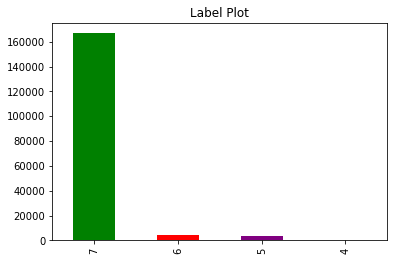

In [6]:
import matplotlib.pyplot as plt
counts = X_train['Number_of_Labels'].value_counts()
print(counts)
counts.plot(kind = 'bar',color = ["green","red", "purple", "yellow"])
plt.title('Label Plot')
plt.show()


This is understandable because most DNS attacks are encrypted, and longer DNS queries are indicative of data being exfiltrated

In [7]:
X_train['Count_of_UpperCase'].nunique()

73

In [8]:
X_train['Average_length_of_Labels'].describe()

count    175000.000000
mean         70.601474
std           8.795603
min           8.600000
25%          67.000000
50%          72.875000
75%          75.875000
max          87.875000
Name: Average_length_of_Labels, dtype: float64

From this, we can see that the dns queries have similar label length as the std is low.

In [9]:
null_data = X_train[X_train.isnull().any(axis=1)]

In [10]:
null_data

,Encoded_data,FQDN_count,Length_of_Subdomain,Number_of_Labels,Maximun_label_length,Average_length_of_Labels,Count_of_Numbers,Count_of_UpperCase,Count_of_LowerCase,Count_of_SpecialChars,Entrophy,subdomain


In [11]:
X_train.isnull().sum().sum()

0

Let us obtain oly the features of our dataset to buil a ML model

In [139]:
train_data = X_train[['FQDN_count', 'Length_of_Subdomain', 'Number_of_Labels',
       'Maximun_label_length', 'Average_length_of_Labels', 'Count_of_Numbers', 'Numeric_percentage',
       'Count_of_UpperCase', 'Count_of_LowerCase', 'Count_of_SpecialChars', 'Special_chars_percentage',
       'Entrophy', 'subdomain']]
train_data

,FQDN_count,Length_of_Subdomain,Number_of_Labels,Maximun_label_length,Average_length_of_Labels,Count_of_Numbers,Numeric_percentage,Count_of_UpperCase,Count_of_LowerCase,Count_of_SpecialChars,Special_chars_percentage,Entrophy,subdomain
0,608,600,7,151,75.500,78,12.828947,54,354,118,19.407895,4.389699,1
1,536,528,7,150,66.500,72,13.432836,40,326,94,17.537313,4.530118,1
2,495,487,7,144,61.375,82,16.565657,38,279,92,18.585859,4.469136,1
3,587,579,7,150,72.875,75,12.776831,49,348,111,18.909710,4.481219,1
4,623,615,7,162,77.375,96,15.409310,41,359,123,19.743178,4.311626,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
174995,602,594,7,150,74.750,89,14.784053,49,344,116,19.269103,4.426524,1
174996,501,493,7,142,62.125,74,14.770459,38,291,94,18.762475,4.493035,1
174997,626,618,7,163,77.750,105,16.773163,41,352,124,19.808307,4.335566,1
174998,543,535,7,153,67.375,69,12.707182,36,326,108,19.889503,4.230303,1


In [143]:
# use a sample of 60000 for training
train_data2 = train_data.sample(n=40000, random_state=71)
train_data2 = train_data2.reset_index(drop=True)
train_data2

,FQDN_count,Length_of_Subdomain,Number_of_Labels,Maximun_label_length,Average_length_of_Labels,Count_of_Numbers,Numeric_percentage,Count_of_UpperCase,Count_of_LowerCase,Count_of_SpecialChars,Special_chars_percentage,Entrophy,subdomain
0,614,606,7,154,76.250,89,14.495114,35,366,120,19.543974,4.299411,1
1,548,540,7,145,68.000,93,16.970803,53,300,98,17.883212,4.623219,1
2,554,546,7,153,68.750,77,13.898917,45,328,100,18.050542,4.517491,1
3,572,564,7,145,71.000,80,13.986014,52,330,106,18.531469,4.514750,1
4,608,600,7,156,75.500,85,13.980263,42,359,118,19.407895,4.306744,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,590,582,7,160,73.250,84,14.237288,58,332,112,18.983051,4.457901,1
39996,617,609,7,165,76.625,92,14.910859,39,361,121,19.611021,4.363676,1
39997,528,520,7,162,65.500,67,12.689394,37,317,103,19.507576,4.366319,1
39998,620,612,7,156,77.000,94,15.161290,46,354,122,19.677419,4.373555,1


In [141]:
unencoded_df = pd.read_csv("stateless_features-heavy_text.pcap.csv")

In [142]:
unencoded_df = unencoded_df[['FQDN_count', 'subdomain_length','labels', 'labels_max',
       'labels_average','numeric', 'upper', 'lower', 'special', 'entropy', 'subdomain']]
unencoded_df

,FQDN_count,subdomain_length,labels,labels_max,labels_average,numeric,upper,lower,special,entropy,subdomain
0,25,8,6,7,3.333333,9,0,10,6,2.556642,1
1,25,8,6,7,3.333333,9,0,10,6,2.556642,1
2,24,7,6,7,3.166667,8,0,10,6,2.054029,1
3,24,7,6,7,3.166667,8,0,10,6,2.054029,1
4,27,10,6,7,3.666667,11,0,10,6,2.767195,1
...,...,...,...,...,...,...,...,...,...,...,...
71097,24,7,6,7,3.166667,8,0,10,6,2.054029,1
71098,25,8,6,7,3.333333,9,0,10,6,2.786216,1
71099,25,8,6,7,3.333333,9,0,10,6,2.786216,1
71100,24,7,6,7,3.166667,8,0,10,6,2.054029,1


In [144]:
# get a smaple of 40000 to use for training
unencoded_df = unencoded_df.sample(n=40000, random_state=4)
unencoded_df = unencoded_df.reset_index(drop=True)
unencoded_df

,FQDN_count,subdomain_length,labels,labels_max,labels_average,numeric,upper,lower,special,entropy,subdomain
0,27,10,6,7,3.666667,11,0,10,6,2.570417,1
1,24,7,6,7,3.166667,8,0,10,6,2.054029,1
2,25,8,6,7,3.333333,9,0,10,6,2.556642,1
3,24,7,6,7,3.166667,8,0,10,6,2.054029,1
4,27,10,6,7,3.666667,11,0,10,6,2.570417,1
...,...,...,...,...,...,...,...,...,...,...,...
39995,25,8,6,7,3.333333,9,0,10,6,2.786216,1
39996,24,7,6,7,3.166667,8,0,10,6,2.054029,1
39997,27,10,6,7,3.666667,11,0,10,6,2.570417,1
39998,27,10,6,7,3.666667,11,0,10,6,2.767195,1


In [145]:
unencoded_df = unencoded_df.rename(columns={'subdomain_length': 'Length_of_Subdomain','labels': 'Number_of_Labels', 'labels_max' : 'Maximun_label_length',
       'labels_average': 'Average_length_of_Labels','numeric' : 'Count_of_Numbers', 'upper' : 'Count_of_UpperCase', 'lower': 'Count_of_LowerCase', 'special' : 'Count_of_SpecialChars', 'entropy' : 'Entrophy'})

unencoded_df

,FQDN_count,Length_of_Subdomain,Number_of_Labels,Maximun_label_length,Average_length_of_Labels,Count_of_Numbers,Count_of_UpperCase,Count_of_LowerCase,Count_of_SpecialChars,Entrophy,subdomain
0,27,10,6,7,3.666667,11,0,10,6,2.570417,1
1,24,7,6,7,3.166667,8,0,10,6,2.054029,1
2,25,8,6,7,3.333333,9,0,10,6,2.556642,1
3,24,7,6,7,3.166667,8,0,10,6,2.054029,1
4,27,10,6,7,3.666667,11,0,10,6,2.570417,1
...,...,...,...,...,...,...,...,...,...,...,...
39995,25,8,6,7,3.333333,9,0,10,6,2.786216,1
39996,24,7,6,7,3.166667,8,0,10,6,2.054029,1
39997,27,10,6,7,3.666667,11,0,10,6,2.570417,1
39998,27,10,6,7,3.666667,11,0,10,6,2.767195,1


In [146]:
# add the numeric percentage column
unencoded_df['Numeric_percentage'] = (unencoded_df['Count_of_Numbers'] / unencoded_df['FQDN_count']) * 100

In [147]:
# add the special character percentage column
unencoded_df['Special_chars_percentage'] = (unencoded_df['Count_of_SpecialChars'] / unencoded_df['FQDN_count']) * 100

In [150]:
unencoded_df= unencoded_df[['FQDN_count', 'Length_of_Subdomain', 'Number_of_Labels',
       'Maximun_label_length', 'Average_length_of_Labels', 'Count_of_Numbers', 'Numeric_percentage',
       'Count_of_UpperCase', 'Count_of_LowerCase', 'Count_of_SpecialChars', 'Special_chars_percentage',
       'Entrophy', 'subdomain']]
unencoded_df

,FQDN_count,Length_of_Subdomain,Number_of_Labels,Maximun_label_length,Average_length_of_Labels,Count_of_Numbers,Numeric_percentage,Count_of_UpperCase,Count_of_LowerCase,Count_of_SpecialChars,Special_chars_percentage,Entrophy,subdomain
0,27,10,6,7,3.666667,11,40.740741,0,10,6,22.222222,2.570417,1
1,24,7,6,7,3.166667,8,33.333333,0,10,6,25.000000,2.054029,1
2,25,8,6,7,3.333333,9,36.000000,0,10,6,24.000000,2.556642,1
3,24,7,6,7,3.166667,8,33.333333,0,10,6,25.000000,2.054029,1
4,27,10,6,7,3.666667,11,40.740741,0,10,6,22.222222,2.570417,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,25,8,6,7,3.333333,9,36.000000,0,10,6,24.000000,2.786216,1
39996,24,7,6,7,3.166667,8,33.333333,0,10,6,25.000000,2.054029,1
39997,27,10,6,7,3.666667,11,40.740741,0,10,6,22.222222,2.570417,1
39998,27,10,6,7,3.666667,11,40.740741,0,10,6,22.222222,2.767195,1


In [176]:
new_train =  train_data2.append(unencoded_df)

In [177]:
# mark the records as malicious
new_train['benign']=0
new_train

,FQDN_count,Length_of_Subdomain,Number_of_Labels,Maximun_label_length,Average_length_of_Labels,Count_of_Numbers,Numeric_percentage,Count_of_UpperCase,Count_of_LowerCase,Count_of_SpecialChars,Special_chars_percentage,Entrophy,subdomain,benign
0,614,606,7,154,76.250000,89,14.495114,35,366,120,19.543974,4.299411,1,0
1,548,540,7,145,68.000000,93,16.970803,53,300,98,17.883212,4.623219,1,0
2,554,546,7,153,68.750000,77,13.898917,45,328,100,18.050542,4.517491,1,0
3,572,564,7,145,71.000000,80,13.986014,52,330,106,18.531469,4.514750,1,0
4,608,600,7,156,75.500000,85,13.980263,42,359,118,19.407895,4.306744,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,25,8,6,7,3.333333,9,36.000000,0,10,6,24.000000,2.786216,1,0
39996,24,7,6,7,3.166667,8,33.333333,0,10,6,25.000000,2.054029,1,0
39997,27,10,6,7,3.666667,11,40.740741,0,10,6,22.222222,2.570417,1,0
39998,27,10,6,7,3.666667,11,40.740741,0,10,6,22.222222,2.767195,1,0


Now let us add benign data to the dataset

In [178]:
benign_features = pd.read_csv("stateless_features-benign_1.pcap.csv")
benign_features

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain
0,2020-11-20 13:58:38.988039,26,9,0,10,10,2.742338,6,6,7,3.500000,2,192,13,1
1,2020-11-20 13:58:39.398160,26,9,0,10,10,2.742338,6,6,7,3.500000,2,192,13,1
2,2020-11-20 13:58:39.990691,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1
3,2020-11-20 13:58:40.400893,27,10,0,10,11,2.767195,6,6,7,3.666667,2,192,14,1
4,2020-11-20 13:58:41.636293,24,7,0,10,8,2.054029,6,6,7,3.166667,4,224,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132494,2020-11-20 23:21:52.163381,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1
132495,2020-11-20 23:21:52.573906,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1
132496,2020-11-20 23:21:52.986831,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1
132497,2020-11-20 23:21:53.396946,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1


In [179]:
benign_features = benign_features[['FQDN_count', 'subdomain_length','labels', 'labels_max',
       'labels_average','numeric', 'upper', 'lower', 'special', 'entropy', 'subdomain']]

In [180]:
benign_features = benign_features.rename(columns={'subdomain_length': 'Length_of_Subdomain','labels': 'Number_of_Labels', 'labels_max' : 'Maximun_label_length',
       'labels_average': 'Average_length_of_Labels','numeric' : 'Count_of_Numbers', 'upper' : 'Count_of_UpperCase', 'lower': 'Count_of_LowerCase', 'special' : 'Count_of_SpecialChars', 'entropy' : 'Entrophy'})

benign_features

,FQDN_count,Length_of_Subdomain,Number_of_Labels,Maximun_label_length,Average_length_of_Labels,Count_of_Numbers,Count_of_UpperCase,Count_of_LowerCase,Count_of_SpecialChars,Entrophy,subdomain
0,26,9,6,7,3.500000,10,0,10,6,2.742338,1
1,26,9,6,7,3.500000,10,0,10,6,2.742338,1
2,27,10,6,7,3.666667,11,0,10,6,2.767195,1
3,27,10,6,7,3.666667,11,0,10,6,2.767195,1
4,24,7,6,7,3.166667,8,0,10,6,2.054029,1
...,...,...,...,...,...,...,...,...,...,...,...
132494,27,10,6,7,3.666667,11,0,10,6,2.570417,1
132495,27,10,6,7,3.666667,11,0,10,6,2.570417,1
132496,27,10,6,7,3.666667,11,0,10,6,2.570417,1
132497,27,10,6,7,3.666667,11,0,10,6,2.570417,1


In [181]:
benign_features['Numeric_percentage'] = (benign_features['Count_of_Numbers'] / benign_features['FQDN_count']) * 100

In [182]:
# add the special character percentage column
benign_features['Special_chars_percentage'] = (benign_features['Count_of_SpecialChars'] / benign_features['FQDN_count']) * 100

In [183]:
# rearrange the clolumns
benign_features= benign_features[['FQDN_count', 'Length_of_Subdomain', 'Number_of_Labels',
       'Maximun_label_length', 'Average_length_of_Labels', 'Count_of_Numbers', 'Numeric_percentage',
       'Count_of_UpperCase', 'Count_of_LowerCase', 'Count_of_SpecialChars', 'Special_chars_percentage',
       'Entrophy', 'subdomain']]

In [184]:
# select 60 records
benign_features2 = benign_features.sample(n=60000, random_state=4)
benign_features2 = benign_features2.reset_index(drop=True)
benign_features2['benign'] = 1

In [185]:
new_train =  new_train.append(benign_features2)

In [186]:
new_train

,FQDN_count,Length_of_Subdomain,Number_of_Labels,Maximun_label_length,Average_length_of_Labels,Count_of_Numbers,Numeric_percentage,Count_of_UpperCase,Count_of_LowerCase,Count_of_SpecialChars,Special_chars_percentage,Entrophy,subdomain,benign
0,614,606,7,154,76.250000,89,14.495114,35,366,120,19.543974,4.299411,1,0
1,548,540,7,145,68.000000,93,16.970803,53,300,98,17.883212,4.623219,1,0
2,554,546,7,153,68.750000,77,13.898917,45,328,100,18.050542,4.517491,1,0
3,572,564,7,145,71.000000,80,13.986014,52,330,106,18.531469,4.514750,1,0
4,608,600,7,156,75.500000,85,13.980263,42,359,118,19.407895,4.306744,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,2,0,1,2,2.000000,0,0.000000,2,0,0,0.000000,1.056642,0,1
59996,28,11,6,7,3.833333,12,42.857143,0,10,6,21.428571,2.205789,1,1
59997,11,0,2,7,5.000000,1,9.090909,0,9,1,9.090909,2.375000,0,1
59998,11,0,2,7,5.000000,0,0.000000,0,10,1,9.090909,2.625000,0,1


In [190]:
# shuffle the dataframe 
new_train2 = new_train.sample(frac=1).reset_index(drop=True)

In [191]:
new_train2

,FQDN_count,Length_of_Subdomain,Number_of_Labels,Maximun_label_length,Average_length_of_Labels,Count_of_Numbers,Numeric_percentage,Count_of_UpperCase,Count_of_LowerCase,Count_of_SpecialChars,Special_chars_percentage,Entrophy,subdomain,benign
0,24,7,6,7,3.166667,8,33.333333,0,10,6,25.000000,2.054029,1,0
1,24,7,6,7,3.166667,8,33.333333,0,10,6,25.000000,2.054029,1,1
2,551,543,7,147,68.375000,83,15.063521,44,321,99,17.967332,4.525290,1,0
3,14,0,2,10,6.500000,0,0.000000,0,12,2,14.285714,2.781301,0,1
4,650,642,7,171,80.750000,91,14.000000,46,377,132,20.307692,4.280311,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139995,15,2,3,9,4.333333,0,0.000000,0,13,2,13.333333,3.119549,1,1
139996,27,10,6,7,3.666667,11,40.740741,0,10,6,22.222222,2.570417,1,1
139997,10,0,3,3,2.666667,0,0.000000,0,8,2,20.000000,1.500000,0,1
139998,24,7,6,7,3.166667,8,33.333333,0,10,6,25.000000,2.054029,1,0


Due to some features being significantly larger than others, let us try normalizing the features

In [242]:
xtrain = new_train2[['FQDN_count', 'Length_of_Subdomain', 'Number_of_Labels',
       'Maximun_label_length', 'Average_length_of_Labels', 'Count_of_Numbers', 'Numeric_percentage',
       'Count_of_UpperCase', 'Count_of_LowerCase', 'Count_of_SpecialChars', 'Special_chars_percentage',
       'Entrophy', 'subdomain']]

In [304]:
xtrain.to_csv("xtrain.csv", index=False)

In [243]:
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler
# fit scaler on training data
norm = MinMaxScaler().fit(xtrain)
# transform training data
X_train_norm = norm.transform(xtrain)

In [283]:
ytrain = new_train2['benign'].values

In [305]:
new_train2['benign'].to_csv("ytrain.csv", index=False)

In [30]:
## I have not added this yet
new_train.to_csv("new_train.csv", index=False)


**Preprocessing the test data**

In [195]:
# temp table
columns =['Encoded_data', 'FQDN_count', 'Length_of_Subdomain',  'Number_of_Labels',  'Maximun_label_length', 'Average_length_of_Labels', 'Count_of_Numbers', 'Numeric_percentage', 'Count_of_UpperCase', 'Count_of_LowerCase', 'Count_of_SpecialChars', 'Special_chars_percentage', 'Entrophy' ]
tempFeatures2 = pd.DataFrame(columns=columns)
tempFeatures2

,Encoded_data,FQDN_count,Length_of_Subdomain,Number_of_Labels,Maximun_label_length,Average_length_of_Labels,Count_of_Numbers,Numeric_percentage,Count_of_UpperCase,Count_of_LowerCase,Count_of_SpecialChars,Special_chars_percentage,Entrophy


In [196]:
for index, row in X_test.iterrows():
    tempFeatures2 = tempFeatures2.append({"Encoded_data": row[0],
                                      "FQDN_count": FQDN_count(row[0]),
                                      "Length_of_Subdomain": countOfCharsinSubdomain(row[0]),
                                      "Number_of_Labels": numOfLables(row[0]),
                                      "Maximun_label_length": maxLabelLength(row[0]), 
                                      "Average_length_of_Labels": AvgLengthOfLabels(row[0]), 
                                      "Count_of_Numbers": numOfDigits(row[0]),
                                      "Numeric_percentage": num_percent(row[0]),
                                      "Count_of_UpperCase": countUppercase(row[0]),
                                      "Count_of_LowerCase": countLowerCase(row[0]),
                                      "Count_of_SpecialChars": countSpecialChars(row[0]),
                                      "Special_chars_percentage": special_char_percent(row[0]),
                                      "Entrophy": find_entropy(row[0])}, ignore_index=True)

In [197]:
tempFeatures2

,Encoded_data,FQDN_count,Length_of_Subdomain,Number_of_Labels,Maximun_label_length,Average_length_of_Labels,Count_of_Numbers,Numeric_percentage,Count_of_UpperCase,Count_of_LowerCase,Count_of_SpecialChars,Special_chars_percentage,Entrophy
0,b'0qoacY2\xeeAH\xd4m\xd0\xd7\xf6\xdb\xf0\xbd\x...,617,609,7,153,76.625,91,14.748784,45,356,121,19.611021,4.356736
1,b'0yqa8\xcf\xc9\xd3JiG\xbe\xee\xf8uV\xe9\xc8\x...,638,630,7,155,79.250,95,14.890282,47,364,128,20.062696,4.268468
2,b'0vjbdv\xd2b\xc738\xe2L\xe3B\xc1\xebL\xee\xbf...,501,493,7,157,62.125,78,15.568862,35,290,94,18.762475,4.393889
3,b'0ucat82\xbew\xeesJ\xf9aabacuqe1DxKabag\xca\x...,524,516,7,147,65.000,59,11.259542,55,316,90,17.175573,4.627084
4,b'0ula5Zo\xd8\xfdfg\xf5\xf8\xea\xe4W\xcci\xd0\...,563,555,7,154,69.875,73,12.966252,53,330,103,18.294849,4.527153
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74995,b'0bjbst\xe048\xd9\xc6\xd8K\xf8\xd3\xd2I\xc8YJ...,486,478,7,145,60.250,83,17.078189,42,268,89,18.312757,4.533155
74996,b'0eeah82\xbew\xeesJ\xf9aabacuqe1m\xc1Kabag\xe...,524,516,7,132,65.000,85,16.221374,48,297,90,17.175573,4.656191
74997,b'0bcal\xed5k\xcd0M\xdb\xf6X\xde\xc1U\xe1ZG\xe...,608,600,7,160,75.500,100,16.447368,49,337,118,19.407895,4.393216
74998,b'0i2a7d\xe8r\xd6\xe4\xc4\xbc4S\xe9\xe6\xdf\xc...,623,615,7,159,77.375,96,15.409310,35,365,123,19.743178,4.299324


In [198]:
X_test =  tempFeatures2.copy()

In [199]:
X_test.to_csv("Test3_Data.csv", index=False)

In [200]:
X_test = pd.read_csv("Test3_Data.csv")
X_test

,Encoded_data,FQDN_count,Length_of_Subdomain,Number_of_Labels,Maximun_label_length,Average_length_of_Labels,Count_of_Numbers,Numeric_percentage,Count_of_UpperCase,Count_of_LowerCase,Count_of_SpecialChars,Special_chars_percentage,Entrophy
0,b'0qoacY2\xeeAH\xd4m\xd0\xd7\xf6\xdb\xf0\xbd\x...,617,609,7,153,76.625,91,14.748784,45,356,121,19.611021,4.356736
1,b'0yqa8\xcf\xc9\xd3JiG\xbe\xee\xf8uV\xe9\xc8\x...,638,630,7,155,79.250,95,14.890282,47,364,128,20.062696,4.268468
2,b'0vjbdv\xd2b\xc738\xe2L\xe3B\xc1\xebL\xee\xbf...,501,493,7,157,62.125,78,15.568862,35,290,94,18.762475,4.393889
3,b'0ucat82\xbew\xeesJ\xf9aabacuqe1DxKabag\xca\x...,524,516,7,147,65.000,59,11.259542,55,316,90,17.175573,4.627084
4,b'0ula5Zo\xd8\xfdfg\xf5\xf8\xea\xe4W\xcci\xd0\...,563,555,7,154,69.875,73,12.966252,53,330,103,18.294849,4.527153
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74995,b'0bjbst\xe048\xd9\xc6\xd8K\xf8\xd3\xd2I\xc8YJ...,486,478,7,145,60.250,83,17.078189,42,268,89,18.312757,4.533155
74996,b'0eeah82\xbew\xeesJ\xf9aabacuqe1m\xc1Kabag\xe...,524,516,7,132,65.000,85,16.221374,48,297,90,17.175573,4.656191
74997,b'0bcal\xed5k\xcd0M\xdb\xf6X\xde\xc1U\xe1ZG\xe...,608,600,7,160,75.500,100,16.447368,49,337,118,19.407895,4.393216
74998,b'0i2a7d\xe8r\xd6\xe4\xc4\xbc4S\xe9\xe6\xdf\xc...,623,615,7,159,77.375,96,15.409310,35,365,123,19.743178,4.299324


In [38]:
X_test.isnull().sum().sum()

0

In [201]:
test_data = X_test[['FQDN_count', 'Length_of_Subdomain', 'Number_of_Labels',
       'Maximun_label_length', 'Average_length_of_Labels', 'Count_of_Numbers', 'Numeric_percentage',
       'Count_of_UpperCase', 'Count_of_LowerCase', 'Count_of_SpecialChars', 'Special_chars_percentage',
       'Entrophy']]

In [202]:
test_data =  test_data.sample(n=25000, random_state=66)
test_data = test_data.reset_index(drop=True)
test_data['subdomain']= 1 
#test_data['benign'] = 0
test_data

,FQDN_count,Length_of_Subdomain,Number_of_Labels,Maximun_label_length,Average_length_of_Labels,Count_of_Numbers,Numeric_percentage,Count_of_UpperCase,Count_of_LowerCase,Count_of_SpecialChars,Special_chars_percentage,Entrophy,subdomain
0,590,582,7,148,73.250,88,14.915254,51,335,112,18.983051,4.480642,1
1,629,621,7,158,78.125,92,14.626391,35,373,125,19.872814,4.280257,1
2,596,588,7,160,74.000,91,15.268456,51,336,114,19.127517,4.450775,1
3,611,603,7,174,75.875,87,14.238953,44,357,119,19.476268,4.373631,1
4,507,499,7,147,62.875,73,14.398422,40,294,96,18.934911,4.393554,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,581,573,7,150,72.125,84,14.457831,35,349,109,18.760757,4.373345,1
24996,584,576,7,145,72.500,97,16.609589,52,321,110,18.835616,4.511137,1
24997,632,624,7,172,78.500,86,13.607595,49,367,126,19.936709,4.329482,1
24998,566,558,7,151,70.250,75,13.250883,45,338,104,18.374558,4.539023,1


In [203]:
test_mal_unencoded = pd.read_csv("stateless_features-heavy_video.pcap.csv")
test_mal_unencoded

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain
0,2020-11-24 17:00:44.878565,26,9,0,10,10,2.742338,6,6,7,3.500000,2,192,13,1
1,2020-11-24 17:00:45.288833,26,9,0,10,10,2.742338,6,6,7,3.500000,2,192,13,1
2,2020-11-24 17:00:45.701472,24,7,0,10,8,2.054029,6,6,7,3.166667,4,224,11,1
3,2020-11-24 17:00:46.111775,24,7,0,10,8,2.054029,6,6,7,3.166667,4,224,11,1
4,2020-11-24 17:00:47.347079,26,9,0,10,10,2.742338,6,6,7,3.500000,2,192,13,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38007,2020-11-24 23:16:24.708760,24,7,0,10,8,2.054029,6,6,7,3.166667,4,224,11,1
38008,2020-11-24 23:16:25.121017,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1
38009,2020-11-24 23:16:25.531377,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1
38010,2020-11-24 23:16:25.943739,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1


In [204]:
test_mal_unencoded = test_mal_unencoded[['FQDN_count', 'subdomain_length','labels', 'labels_max',
       'labels_average','numeric', 'upper', 'lower', 'special', 'entropy', 'subdomain']]
test_mal_unencoded

,FQDN_count,subdomain_length,labels,labels_max,labels_average,numeric,upper,lower,special,entropy,subdomain
0,26,9,6,7,3.500000,10,0,10,6,2.742338,1
1,26,9,6,7,3.500000,10,0,10,6,2.742338,1
2,24,7,6,7,3.166667,8,0,10,6,2.054029,1
3,24,7,6,7,3.166667,8,0,10,6,2.054029,1
4,26,9,6,7,3.500000,10,0,10,6,2.742338,1
...,...,...,...,...,...,...,...,...,...,...,...
38007,24,7,6,7,3.166667,8,0,10,6,2.054029,1
38008,27,10,6,7,3.666667,11,0,10,6,2.570417,1
38009,27,10,6,7,3.666667,11,0,10,6,2.570417,1
38010,27,10,6,7,3.666667,11,0,10,6,2.570417,1


In [205]:
test_mal_unencoded = test_mal_unencoded.rename(columns={'subdomain_length': 'Length_of_Subdomain','labels': 'Number_of_Labels', 'labels_max' : 'Maximun_label_length',
       'labels_average': 'Average_length_of_Labels','numeric' : 'Count_of_Numbers', 'upper' : 'Count_of_UpperCase', 'lower': 'Count_of_LowerCase', 'special' : 'Count_of_SpecialChars', 'entropy' : 'Entrophy'})

test_mal_unencoded

,FQDN_count,Length_of_Subdomain,Number_of_Labels,Maximun_label_length,Average_length_of_Labels,Count_of_Numbers,Count_of_UpperCase,Count_of_LowerCase,Count_of_SpecialChars,Entrophy,subdomain
0,26,9,6,7,3.500000,10,0,10,6,2.742338,1
1,26,9,6,7,3.500000,10,0,10,6,2.742338,1
2,24,7,6,7,3.166667,8,0,10,6,2.054029,1
3,24,7,6,7,3.166667,8,0,10,6,2.054029,1
4,26,9,6,7,3.500000,10,0,10,6,2.742338,1
...,...,...,...,...,...,...,...,...,...,...,...
38007,24,7,6,7,3.166667,8,0,10,6,2.054029,1
38008,27,10,6,7,3.666667,11,0,10,6,2.570417,1
38009,27,10,6,7,3.666667,11,0,10,6,2.570417,1
38010,27,10,6,7,3.666667,11,0,10,6,2.570417,1


In [206]:
# add the numeric percentage column
test_mal_unencoded['Numeric_percentage'] = (test_mal_unencoded['Count_of_Numbers'] / test_mal_unencoded['FQDN_count']) * 100

In [207]:
# add the special character percentage column
test_mal_unencoded['Special_chars_percentage'] = (test_mal_unencoded['Count_of_SpecialChars'] / test_mal_unencoded['FQDN_count']) * 100

In [208]:
test_mal_unencoded= test_mal_unencoded[['FQDN_count', 'Length_of_Subdomain', 'Number_of_Labels',
       'Maximun_label_length', 'Average_length_of_Labels', 'Count_of_Numbers', 'Numeric_percentage',
       'Count_of_UpperCase', 'Count_of_LowerCase', 'Count_of_SpecialChars', 'Special_chars_percentage',
       'Entrophy', 'subdomain']]

In [209]:
# use only 25000 records for testing
test_mal_unencoded =  test_mal_unencoded.sample(n=25000, random_state=66)
test_mal_unencoded = test_mal_unencoded.reset_index(drop=True)

In [210]:
## add the unencoded malicious data to the train dataset
test_data =  test_data.append(test_mal_unencoded)

In [211]:
test_data['benign'] = 0

In [212]:
test_benign_dns = pd.read_csv("stateless_features-benign_heavy_2.pcap.csv")
test_benign_dns

,timestamp,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain
0,2020-11-23 15:06:33.824493,25,8,0,10,9,2.786216,6,6,7,3.333333,2,192,12,1
1,2020-11-23 15:06:34.234586,25,8,0,10,9,2.786216,6,6,7,3.333333,2,192,12,1
2,2020-11-23 15:06:35.469710,24,7,0,10,8,2.054029,6,6,7,3.166667,4,224,11,1
3,2020-11-23 15:06:35.879951,24,7,0,10,8,2.054029,6,6,7,3.166667,4,224,11,1
4,2020-11-23 15:06:37.115122,24,7,0,10,8,2.054029,6,6,7,3.166667,4,224,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49110,2020-11-23 18:21:34.510608,20,3,0,18,0,3.327820,2,3,12,6.000000,numbers,numberspoint,16,1
49111,2020-11-23 18:21:34.727038,10,0,0,9,0,2.406304,1,2,6,4.500000,pin,oyepin,7,0
49112,2020-11-23 18:21:34.767955,10,0,0,9,0,2.406304,1,2,6,4.500000,pin,oyepin,7,0
49113,2020-11-23 18:21:34.788506,25,8,0,10,9,2.786216,6,6,7,3.333333,2,192,12,1


In [213]:
test_benign_dns = test_benign_dns[['FQDN_count', 'subdomain_length','labels', 'labels_max',
       'labels_average','numeric', 'upper', 'lower', 'special', 'entropy', 'subdomain']]
test_benign_dns

,FQDN_count,subdomain_length,labels,labels_max,labels_average,numeric,upper,lower,special,entropy,subdomain
0,25,8,6,7,3.333333,9,0,10,6,2.786216,1
1,25,8,6,7,3.333333,9,0,10,6,2.786216,1
2,24,7,6,7,3.166667,8,0,10,6,2.054029,1
3,24,7,6,7,3.166667,8,0,10,6,2.054029,1
4,24,7,6,7,3.166667,8,0,10,6,2.054029,1
...,...,...,...,...,...,...,...,...,...,...,...
49110,20,3,3,12,6.000000,0,0,18,2,3.327820,1
49111,10,0,2,6,4.500000,0,0,9,1,2.406304,0
49112,10,0,2,6,4.500000,0,0,9,1,2.406304,0
49113,25,8,6,7,3.333333,9,0,10,6,2.786216,1


In [214]:
test_benign_dns = test_benign_dns.rename(columns={'subdomain_length': 'Length_of_Subdomain','labels': 'Number_of_Labels', 'labels_max' : 'Maximun_label_length',
       'labels_average': 'Average_length_of_Labels','numeric' : 'Count_of_Numbers', 'upper' : 'Count_of_UpperCase', 'lower': 'Count_of_LowerCase', 'special' : 'Count_of_SpecialChars', 'entropy' : 'Entrophy'})

test_benign_dns

,FQDN_count,Length_of_Subdomain,Number_of_Labels,Maximun_label_length,Average_length_of_Labels,Count_of_Numbers,Count_of_UpperCase,Count_of_LowerCase,Count_of_SpecialChars,Entrophy,subdomain
0,25,8,6,7,3.333333,9,0,10,6,2.786216,1
1,25,8,6,7,3.333333,9,0,10,6,2.786216,1
2,24,7,6,7,3.166667,8,0,10,6,2.054029,1
3,24,7,6,7,3.166667,8,0,10,6,2.054029,1
4,24,7,6,7,3.166667,8,0,10,6,2.054029,1
...,...,...,...,...,...,...,...,...,...,...,...
49110,20,3,3,12,6.000000,0,0,18,2,3.327820,1
49111,10,0,2,6,4.500000,0,0,9,1,2.406304,0
49112,10,0,2,6,4.500000,0,0,9,1,2.406304,0
49113,25,8,6,7,3.333333,9,0,10,6,2.786216,1


In [215]:
# add the Numeric_percentage column
test_benign_dns['Numeric_percentage'] = (test_benign_dns['Count_of_Numbers'] / test_benign_dns['FQDN_count']) * 100

In [216]:
# add the special character percentage column
test_benign_dns['Special_chars_percentage'] = (test_benign_dns['Count_of_SpecialChars'] / test_benign_dns['FQDN_count']) * 100

In [217]:
test_benign_dns= test_benign_dns[['FQDN_count', 'Length_of_Subdomain', 'Number_of_Labels',
       'Maximun_label_length', 'Average_length_of_Labels', 'Count_of_Numbers', 'Numeric_percentage',
       'Count_of_UpperCase', 'Count_of_LowerCase', 'Count_of_SpecialChars', 'Special_chars_percentage',
       'Entrophy', 'subdomain']]

In [218]:
# use only 40000 records for testing and mark them as benign records
test_benign_dns =  test_benign_dns.sample(n=40000, random_state=21)
test_benign_dns = test_benign_dns.reset_index(drop=True)
test_benign_dns['benign'] = 1
test_benign_dns

,FQDN_count,Length_of_Subdomain,Number_of_Labels,Maximun_label_length,Average_length_of_Labels,Count_of_Numbers,Numeric_percentage,Count_of_UpperCase,Count_of_LowerCase,Count_of_SpecialChars,Special_chars_percentage,Entrophy,subdomain,benign
0,10,0,2,7,4.500000,0,0.000000,0,8,2,20.000000,2.625000,0,1
1,32,0,1,32,32.000000,0,0.000000,32,0,0,0.000000,2.674526,0,1
2,27,10,6,7,3.666667,11,40.740741,0,10,6,22.222222,2.570417,1,1
3,19,3,3,11,5.666667,0,0.000000,0,17,2,10.526316,2.879113,1,1
4,9,0,2,5,4.000000,0,0.000000,0,8,1,11.111111,2.154135,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,24,7,6,7,3.166667,8,33.333333,0,10,6,25.000000,2.054029,1,1
39996,12,0,2,8,5.500000,0,0.000000,0,11,1,8.333333,2.373267,0,1
39997,6,0,2,3,2.500000,0,0.000000,0,5,1,16.666667,1.500000,0,1
39998,32,0,1,32,32.000000,0,0.000000,32,0,0,0.000000,2.735132,0,1


In [219]:
## add the benign data to the train dataset
test_data =  test_data.append(test_benign_dns)
test_data = test_data.sample(frac=1).reset_index(drop=True)

In [245]:
xtest = test_data[['FQDN_count', 'Length_of_Subdomain', 'Number_of_Labels',
       'Maximun_label_length', 'Average_length_of_Labels', 'Count_of_Numbers', 'Numeric_percentage',
       'Count_of_UpperCase', 'Count_of_LowerCase', 'Count_of_SpecialChars', 'Special_chars_percentage',
       'Entrophy', 'subdomain']]
xtest

,FQDN_count,Length_of_Subdomain,Number_of_Labels,Maximun_label_length,Average_length_of_Labels,Count_of_Numbers,Numeric_percentage,Count_of_UpperCase,Count_of_LowerCase,Count_of_SpecialChars,Special_chars_percentage,Entrophy,subdomain
0,15,3,3,7,4.333333,0,0.000000,0,13,2,13.333333,2.712675,1
1,7,0,2,3,3.000000,0,0.000000,0,6,1,14.285714,1.500000,0
2,7,0,2,4,3.000000,0,0.000000,0,6,1,14.285714,1.857542,0
3,23,3,4,13,5.000000,0,0.000000,0,20,3,13.043478,3.214383,1
4,24,7,6,7,3.166667,8,33.333333,0,10,6,25.000000,2.054029,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,13,3,4,3,2.500000,0,0.000000,0,10,3,23.076923,1.727035,1
89996,629,621,7,172,78.125000,88,13.990461,40,372,125,19.872814,4.339610,1
89997,10,0,2,7,4.500000,0,0.000000,0,9,1,10.000000,2.375000,0
89998,23,3,3,15,7.000000,0,0.000000,0,21,2,8.695652,3.353043,1


In [301]:
xtest.to_csv("xtest.csv", index=False)

In [247]:
X_test_norm = norm.transform(xtest)

In [284]:
ytest = test_data['benign'].values

In [303]:
test_data['benign'].to_csv("ytest.csv", index=False)

In [320]:
def precision(actualTags, predictions, classOfInterest):
    '''
    Calculates the precision for a specific class, given the ground truth and predicted values.
    '''
    totalFound = 0
    for i in range(len(actualTags)):
        if (actualTags[i] == classOfInterest and actualTags[i] == predictions[i]):
            totalFound += 1
    return totalFound / np.count_nonzero(predictions == classOfInterest)

In [321]:
def recall(actualTags, predictions, classOfInterest):
    '''
    Calculates the recall for a specific class, given the ground truth and predicted values.
    '''
    totalFound = 0
    for i in range(len(actualTags)):
        if (actualTags[i] == classOfInterest and actualTags[i] == predictions[i]):
            totalFound += 1
    return totalFound / np.count_nonzero(actualTags == classOfInterest)

In [322]:
def accuracy(actualTags, predictions):
    '''
    Calculates the average number of correct predictions.
        - actualTags: The ground truth
        - predictions: What the model predicts
    '''
    totalFound = 0
    for i in range(len(actualTags)):
        if (actualTags[i] == predictions[i]):
            totalFound += 1
    return totalFound / len(predictions)

**Feature Enginieering done**

<b>Now that we have our train and test data let us run some models with it </b>

**Logistic Regression**

In [226]:
# Import the Logistic Regression model from scikit and matplot
from sklearn.metrics import recall_score, precision_score
from sklearn.linear_model import LogisticRegression
import datetime

In [248]:
# Define the model
clf_lr = LogisticRegression(solver='sag', random_state=1, warm_start=True)

In [265]:
clf_lr.fit(X_train_norm, ytrain.ravel())

LogisticRegression(random_state=1, solver='sag', warm_start=True)

In [255]:
print(type(lr_val_predictions))

<class 'numpy.ndarray'>


Next, we will view how the model performs on the training data to get an idea as to how the training went. Since we trained on this data, we will hopefully have strong results.

In [291]:
# Get the predictions for the validation set
lr_val_predictions = clf_lr.predict(X_test_norm)
# Retrieve and print the precision values for class 1 and class 0
print("Precision for the dns attacks: " + str(precision(ytest,lr_val_predictions, 0)))
print("Precision for benign dns: " + str(precision(ytest,lr_val_predictions, 1)))
# Retrieve and print the recall values for class 1 and class 0
print("Recall for the dns attacks: " + str(recall(ytest,lr_val_predictions, 0)))
print("Recall for benign dns: " + str(recall(ytest,lr_val_predictions, 1)))
# Retrieve and print the accuracy for the model
print("Accuracy: " + str(accuracy(ytest,lr_val_predictions)))
recall = recall_score(lr_val_predictions, ytest,average=None) * 100
precision = precision_score(lr_val_predictions, ytest,average=None) * 100
print("Mean Recall:" , np.mean(recall))
print("Mean Precision:" , np.mean(precision))

Precision for the dns attacks: 0.7580288269461262
Precision for benign dns: 0.9731562474921756
Recall for the dns attacks: 0.98662
Recall for benign dns: 0.606325
Accuracy: 0.8176
Mean Recall: 86.5592537219151
Mean Precision: 79.64725


**MLP**

In [277]:
# Import the MLP model from scikit and matplot
from sklearn.neural_network import MLPClassifier

In [278]:
# Define the model
clf_mlp = MLPClassifier(solver='sgd', hidden_layer_sizes=(60), random_state=34, warm_start=True)

In [294]:
clf_mlp.fit(X_train_norm, ytrain.ravel())

MLPClassifier(hidden_layer_sizes=60, random_state=34, solver='sgd',
              warm_start=True)

In [299]:
# Get the predictions for the validation set
mlp_predictions = clf_mlp.predict(X_test_norm)
# Retrieve and print the precision values for class 1 and class 0
print("Precision for the dns attacks: " + str(precision(ytest,mlp_predictions, 0)))
print("Precision for benign dns: " + str(precision(ytest,mlp_predictions, 1)))
# Retrieve and print the recall values for class 1 and class 0
print("Recall for the dns attacks: " + str(recall(ytest,mlp_predictions, 0)))
print("Recall for benign dns: " + str(recall(ytest,mlp_predictions, 1)))
# Retrieve and print the accuracy for the model
print("Accuracy: " + str(accuracy(ytest,mlp_predictions)))
recall = recall_score(mlp_predictions, ytest,average=None) * 100
precision = precision_score(mlp_predictions, ytest,average=None) * 100
print("Mean Recall:" , np.mean(recall))
print("Mean Precision:" , np.mean(precision))

Precision for the dns attacks: 0.7582081289310594
Precision for benign dns: 0.9721299002923157
Recall for the dns attacks: 0.98608
Recall for benign dns: 0.606925
Accuracy: 0.8175666666666667
Mean Recall: 86.51690146116876
Mean Precision: 79.65025


**Decision Tree**

In [287]:
from sklearn.tree import DecisionTreeClassifier
#This step is to train our classifier based on the training data.
dt = DecisionTreeClassifier(criterion='entropy')
#
#criterion='entropy',max_depth=None
dt.fit(X_train_norm, ytrain.ravel())

DecisionTreeClassifier(criterion='entropy')

In [310]:
# Get the predictions for the validation set
y_pred = dt.predict(X_test_norm)
# Retrieve and print the precision values for class 1 and class 0
print("Precision for the dns attacks: " + str(precision(ytest,y_pred, 0)))
print("Precision for benign dns: " + str(precision(ytest,y_pred, 1)))
# Retrieve and print the recall values for class 1 and class 0
print("Recall for the dns attacks: " + str(recall(ytest,y_pred, 0)))
print("Recall for benign dns: " + str(recall(ytest,y_pred, 1)))
# Retrieve and print the accuracy for the model
print("Accuracy: " + str(accuracy(ytest,y_pred)))
recall = recall_score(y_pred, ytest,average=None) * 100
precision = precision_score(y_pred, ytest,average=None) * 100
print("Mean Recall:" , np.mean(recall))
print("Mean Precision:" , np.mean(precision))

Precision for the dns attacks: 0.7557350222734023
Precision for benign dns: 0.994875427047746
Recall for the dns attacks: 0.99754
Recall for benign dns: 0.596975
Accuracy: 0.8195111111111111
Mean Recall: 87.53052246605742
Mean Precision: 79.72575


In [326]:
from sklearn.tree import export_text
r = export_text(dt, feature_names=['FQDN_count', 'Length_of_Subdomain', 'Number_of_Labels', 'Maximun_label_length', 'Average_length_of_Labels', 'Count_of_Numbers', 'Numeric_percentage', 'Count_of_UpperCase', 'Count_of_LowerCase', 'Count_of_SpecialChars', 'Special_chars_percentage', 'Entrophy', 'subdomain'])
print(r)

|--- FQDN_count <= 0.03
|   |--- Number_of_Labels <= 0.08
|   |   |--- Count_of_LowerCase <= 0.02
|   |   |   |--- Count_of_UpperCase <= 0.01
|   |   |   |   |--- Entrophy <= 0.38
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Entrophy >  0.38
|   |   |   |   |   |--- class: 0
|   |   |   |--- Count_of_UpperCase >  0.01
|   |   |   |   |--- Special_chars_percentage <= 0.10
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Special_chars_percentage >  0.10
|   |   |   |   |   |--- class: 0
|   |   |--- Count_of_LowerCase >  0.02
|   |   |   |--- class: 1
|   |--- Number_of_Labels >  0.08
|   |   |--- Length_of_Subdomain <= 0.01
|   |   |   |--- Length_of_Subdomain <= 0.01
|   |   |   |   |--- Entrophy <= 0.27
|   |   |   |   |   |--- Special_chars_percentage <= 0.32
|   |   |   |   |   |   |--- Entrophy <= 0.27
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- Entrophy >  0.27
|   |   |   |   |   |   |   |--- Average_length_of_Labels <= 0.04
|   |   |   

**Gradient Boosting**

In [81]:
from sklearn.ensemble import GradientBoostingClassifier

In [312]:
gb = GradientBoostingClassifier()
gb.fit(X_train_norm, ytrain.ravel())

GradientBoostingClassifier()

In [317]:
# Get the predictions for the validation set
y_pred = gb.predict(X_test_norm)
# Retrieve and print the precision values for class 1 and class 0
print("Precision for the dns attacks: " + str(precision(ytest,y_pred, 0)))
print("Precision for benign dns: " + str(precision(ytest,y_pred, 1)))
# Retrieve and print the recall values for class 1 and class 0
print("Recall for the dns attacks: " + str(recall(ytest,y_pred, 0)))
print("Recall for benign dns: " + str(recall(ytest,y_pred, 1)))
# Retrieve and print the accuracy for the model
print("Accuracy: " + str(accuracy(ytest,y_pred)))
recall = recall_score(y_pred, ytest,average=None) * 100
precision = precision_score(y_pred, ytest,average=None) * 100
print("Mean Recall:" , np.mean(recall))
print("Mean Precision:" , np.mean(precision))

Precision for the dns attacks: 0.7556665153578453
Precision for benign dns: 0.9975742367210372
Recall for the dns attacks: 0.99884
Recall for benign dns: 0.5963
Accuracy: 0.8199333333333333
Mean Recall: 87.66203760394413
Mean Precision: 79.757


**Random Forest**

In [85]:
from sklearn.ensemble import RandomForestClassifier

In [318]:
clf = RandomForestClassifier()
clf.fit(X_train_norm, ytrain.ravel())

RandomForestClassifier()

In [323]:
# Get the predictions for the validation set
y_pred = clf.predict(X_test_norm)
# Retrieve and print the precision values for class 1 and class 0
print("Precision for the dns attacks: " + str(precision(ytest,y_pred, 0)))
print("Precision for benign dns: " + str(precision(ytest,y_pred, 1)))
# Retrieve and print the recall values for class 1 and class 0
print("Recall for the dns attacks: " + str(recall(ytest,y_pred, 0)))
print("Recall for benign dns: " + str(recall(ytest,y_pred, 1)))
# Retrieve and print the accuracy for the model
print("Accuracy: " + str(accuracy(ytest,y_pred)))
recall = recall_score(y_pred, ytest,average=None) * 100
precision = precision_score(y_pred, ytest,average=None) * 100
print("Mean Recall:" , np.mean(recall))
print("Mean Precision:" , np.mean(precision))

Precision for the dns attacks: 0.7559297373486307
Precision for benign dns: 0.9948790540821849
Recall for the dns attacks: 0.99754
Recall for benign dns: 0.5974
Accuracy: 0.8197
Mean Recall: 87.54043957154079
Mean Precision: 79.747
